In [1]:
import os
import sys
import numpy as np
from sklearn.model_selection import train_test_split

sys.path.insert(0, "../")
from tabmap.dataloader.dataset import load_data
from tabmap.hparams_tuner.dl_models_tuner import DLModelTuner
from tabmap.evaluate_model import Model_Evaluation
from tabmap.tabmap_construction import TabMapGenerator
from tabmap.utils.tabmap_visualization import plot_tabmap

### Load example dataset Isolet
Dataset source: [Isolet](https://archive.ics.uci.edu/dataset/54/isolet)

In [2]:
data_path='../data'
data_set='isolet'

# Define paths and ensure directory existence
data_dir = os.path.join(data_path, data_set)
os.makedirs(os.path.dirname(data_dir), exist_ok=True)

# Load the dataset and perform data preprocessing (minmax scaling)
X, y, feature_names = load_data(data_dir, scaler_name='minmax', preprocessed=False)
n_classes = len(np.unique(y))

# Define paths to save classification results
results_path = '../results'

Performing data preprocessing...
Discarded features: []


In [3]:
X.shape # shape: (n_samples, n_features)

(7797, 617)

### Basic Usages
- tabmap construction and visualization
- tabmap-based CNN classifier

In [4]:
seed = 42
model_id = 'TabMap'

# Splits the data into training, validation, and test sets.
# first split: Train + Validation and Test
train_idx_all, test_idx = train_test_split(np.arange(len(y)), test_size=0.25, random_state=seed)
# second split: Train and Validation
train_idx, valid_idx = train_test_split(train_idx_all, test_size=0.125, random_state=seed, stratify=y[train_idx_all])

In [5]:
# Fits the TabMapGenerator and transforms the data into image representations.
generator = TabMapGenerator(metric='euclidean', loss_fun='kl_loss')
generator.fit(X[train_idx_all], truncate=False)
X_img = generator.transform(X)

# this is recommended as our model training will load saved files.
save_path = os.path.join(data_dir, f"{model_id}.npy")
np.save(save_path, X_img)
print(f"Images saved to {save_path}")

Solving optimization problem...
Images saved to ../data/isolet/TabMap.npy


(<Figure size 300x300 with 2 Axes>, <Axes: >)

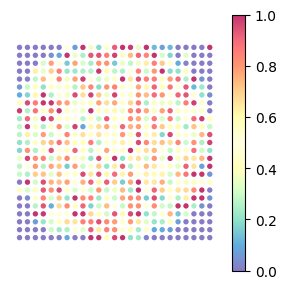

In [6]:
# Visualization
plot_tabmap(X_img[0])

In [7]:
# Creates a data configuration dictionary.
data_config = dict(
    data_set = data_set,
    data_dir = data_dir,
    n_classes = n_classes,
    input_size = X_img.shape[1:],
)

In [8]:
# Initialize and run model tuner
# Set use_default_hparams=False to enable hyperparameter tuning
tuner = DLModelTuner(
        data_config=data_config,
        train_idx=train_idx,
        valid_idx=valid_idx,
        model_id=model_id,
        results_path=results_path,
        use_default_hparams=True,
        opt_metric='balanced_accuracy',
        random_seed=seed
    )

Epoch 19/30: Train Loss: 0.0000, Val Loss: 0.0030, Val Acc: 0.9697
Early stopping triggered


In [9]:
# Evaluate the model
model_eval = Model_Evaluation(model_id)
_, y_pred = model_eval.model_predict(tuner.final_model, X=X_img[test_idx])
performance_test = model_eval.prediction_performance(y[test_idx].ravel(), y_pred.ravel())
performance_test

{'model': 'TabMap', 'BA': 0.9642, 'F1': 0.9638, 'MCC': 0.9621}